# 01 — Data Loading & EDA
**Goal:** Load the weather dataset, clean missing/outliers, create a tidy per-city time series, and explore trends/seasonality.  
**Outputs:** `assets/clean_weather.parquet` (tidy data), key EDA plots saved to `assets/`.

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (10, 5)

# Make src/ importable + import simple helpers
import sys
sys.path.append("..")
from src.data import (
    load_raw, save_clean,
    clean_basic, keep_columns, filter_cities,
    fill_missing, clip_outliers_iqr, add_time_features
)

In [17]:
# load raw data using src/data.py

df = load_raw()  # reads ../data/GlobalWeatherRepository.csv by default

print(df.shape)
display(df.head())



(88468, 41)


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,wind_kph,wind_degree,wind_direction,pressure_mb,pressure_in,precip_mm,precip_in,humidity,cloud,feels_like_celsius,feels_like_fahrenheit,visibility_km,visibility_miles,uv_index,gust_mph,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,8.3,13.3,338,NNW,1012.0,29.89,0.0,0.00,24,30,25.3,77.5,10.0,6.0,7.0,9.5,15.3,277.0,103.0,1.1,0.2,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,6.9,11.2,320,NW,1012.0,29.88,0.1,0.00,94,75,19.0,66.2,10.0,6.0,5.0,11.4,18.4,193.6,97.3,0.9,0.1,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,9.4,15.1,280,W,1011.0,29.85,0.0,0.00,29,0,24.6,76.4,10.0,6.0,5.0,13.9,22.3,540.7,12.2,65.1,13.4,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,7.4,11.9,215,SW,1007.0,29.75,0.3,0.01,61,100,3.8,38.9,2.0,1.0,2.0,8.5,13.7,170.2,64.4,1.6,0.2,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,8.1,13.0,150,SSE,1011.0,29.85,0.0,0.00,89,50,28.7,83.6,10.0,6.0,8.0,12.5,20.2,2964.0,19.0,72.7,31.5,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [4]:
# Columns and data types


print("\nColumn names:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
TIME_COL  = "last_updated"
CITY_COL  = "location_name"
COUNTRY_COL = "country"

NUM_COLS = [
    "temperature_celsius", "feels_like_celsius", "humidity",
    "pressure_mb", "wind_kph", "precip_mm", "cloud", "uv_index"
]

CITIES = ["London", "New York", "Tokyo"]

ASSETS = Path("../assets")
ASSETS.mkdir(parents=True, exist_ok=True)


Column names: ['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']

Data types:
 country                          object
location_name                    object
latitude                        float64
longitude                       float64
timezone                         object
last_updated_epoch                int64
last_updated 

In [5]:
# Clean and Standardize 

df = clean_basic(df, time_col=TIME_COL)

In [6]:
# Data Quality check

# Missing values (%)
missing_pct = df.isna().mean().sort_values(ascending=False).to_frame("missing_pct")
display(missing_pct.head(20))

# Unique counts
print(f"Cities: {df[CITY_COL].nunique() if CITY_COL in df.columns else 'N/A'}")
if COUNTRY_COL and COUNTRY_COL in df.columns:
    print(f"Countries: {df[COUNTRY_COL].nunique()}")

,missing_pct
country,0.0
location_name,0.0
latitude,0.0
longitude,0.0
timezone,0.0
last_updated_epoch,0.0
last_updated,0.0
temperature_celsius,0.0
temperature_fahrenheit,0.0
condition_text,0.0


Cities: 248
Countries: 210


In [7]:
# Keep only relevant columns

df = keep_columns(df, TIME_COL, CITY_COL, COUNTRY_COL, NUM_COLS, include_geo=True)
print(f"\nShape after trimming: {df.shape}")
df.head()


Shape after trimming: (88468, 13)


,last_updated,location_name,country,latitude,longitude,temperature_celsius,feels_like_celsius,humidity,pressure_mb,wind_kph,precip_mm,cloud,uv_index
0,2024-05-16 01:45:00+00:00,Washington Park,United States of America,46.60,-120.49,16.1,16.1,58,1012.0,6.8,0.00,0,1.0
1,2024-05-16 02:45:00+00:00,San Juan,Costa Rica,9.97,-84.08,21.0,21.0,100,1016.0,3.6,0.17,75,1.0
2,2024-05-16 02:45:00+00:00,Tegucigalpa,Honduras,14.10,-87.22,23.0,25.3,78,1017.0,6.1,0.28,37,1.0
3,2024-05-16 02:45:00+00:00,Managua,Nicaragua,12.15,-86.27,27.2,30.6,80,1009.0,5.8,0.01,75,1.0
4,2024-05-16 02:45:00+00:00,Belmopan,Belize,17.25,-88.77,26.0,29.6,89,1007.0,6.8,0.00,94,1.0


In [8]:
# Filter representation of the city and set index

df, cities_present = filter_cities(df, CITY_COL, CITIES, TIME_COL)
print("Using cities:", cities_present)
df.head()


Using cities: ['London', 'New York', 'Tokyo']


,location_name,country,latitude,longitude,temperature_celsius,feels_like_celsius,humidity,pressure_mb,wind_kph,precip_mm,cloud,uv_index
last_updated,,,,,,,,,,,,
2024-05-16 09:45:00+00:00,London,United Kingdom,51.52,-0.11,14.0,14.5,88,1005.0,4.0,0.20,50,3.0
2024-05-16 15:15:00+00:00,London,United Kingdom,51.52,-0.11,15.0,15.1,77,1005.0,11.2,0.01,50,3.0
2024-05-16 17:45:00+00:00,Tokyo,Japan,35.69,139.69,24.0,25.3,47,1001.0,33.1,0.00,25,6.0
2024-05-16 23:00:00+00:00,Tokyo,Japan,35.69,139.69,18.3,18.3,44,1005.0,19.1,0.00,0,1.0
2024-05-17 17:15:00+00:00,London,United Kingdom,51.52,-0.11,21.0,21.0,43,1010.0,6.1,0.40,0,4.0


In [9]:
# Handle Missinging Values 

df_clean = fill_missing(df, CITY_COL, NUM_COLS)
df_clean.isna().sum()


/Users/jibinkunjumon/Downloads/pmacc-weather-datasci/notebooks/../src/data.py:95: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.ffill().bfill())


location_name          0
country                0
latitude               0
longitude              0
temperature_celsius    0
feels_like_celsius     0
humidity               0
pressure_mb            0
wind_kph               0
precip_mm              0
cloud                  0
uv_index               0
dtype: int64

In [10]:
#  Outlier Clipping - IQR

df_clean = clip_outliers_iqr(df_clean, CITY_COL, NUM_COLS, k=1.5)
df_clean.describe().T


,count,mean,std,min,25%,50%,75%,max
latitude,909.0,43.583218,7.914718,35.6895,35.6895,35.69,51.5171,51.5200
longitude,909.0,69.787512,70.061983,-74.0100,-0.1062,139.69,139.6917,139.6917
temperature_celsius,909.0,17.250385,8.065994,-1.9000,10.3000,17.40,23.0000,37.1000
feels_like_celsius,909.0,17.250605,10.027733,-4.8000,9.3000,17.40,24.7000,46.9000
humidity,909.0,69.356436,17.788234,21.0000,57.0000,71.00,83.0000,100.0000
pressure_mb,909.0,1014.009351,8.646679,990.5000,1008.0000,1014.00,1020.0000,1042.5000
wind_kph,909.0,16.186909,8.291294,3.6000,10.1000,15.50,21.2000,43.4500
precip_mm,909.0,0.009670,0.016537,0.0000,0.0000,0.00,0.0200,0.0500
cloud,909.0,45.509351,30.495381,0.0000,25.0000,50.00,75.0000,100.0000
uv_index,909.0,1.432673,1.782662,0.0000,0.1000,0.90,2.0000,8.0000


In [11]:
# Adding time features 

df_features = add_time_features(df_clean)  # expects datetime index already
df_features.head()


,location_name,country,latitude,longitude,temperature_celsius,feels_like_celsius,humidity,pressure_mb,wind_kph,precip_mm,cloud,uv_index,year,month,dayofyear,dow,sin_doy,cos_doy
last_updated,,,,,,,,,,,,,,,,,,
2024-05-16 09:45:00+00:00,London,United Kingdom,51.52,-0.11,14.0,14.5,88,1005.0,4.0,0.025,50,3.0,2024,5,137,3,0.706727,-0.707487
2024-05-16 15:15:00+00:00,London,United Kingdom,51.52,-0.11,15.0,15.1,77,1005.0,11.2,0.010,50,3.0,2024,5,137,3,0.706727,-0.707487
2024-05-16 17:45:00+00:00,Tokyo,Japan,35.69,139.69,24.0,25.3,47,1001.0,33.1,0.000,25,2.5,2024,5,137,3,0.706727,-0.707487
2024-05-16 23:00:00+00:00,Tokyo,Japan,35.69,139.69,18.3,18.3,44,1005.0,19.1,0.000,0,1.0,2024,5,137,3,0.706727,-0.707487
2024-05-17 17:15:00+00:00,London,United Kingdom,51.52,-0.11,21.0,21.0,43,1010.0,6.1,0.025,0,4.0,2024,5,138,4,0.694452,-0.719539


Saved: ../assets/temperature_celsius_ALL_CITIES.png


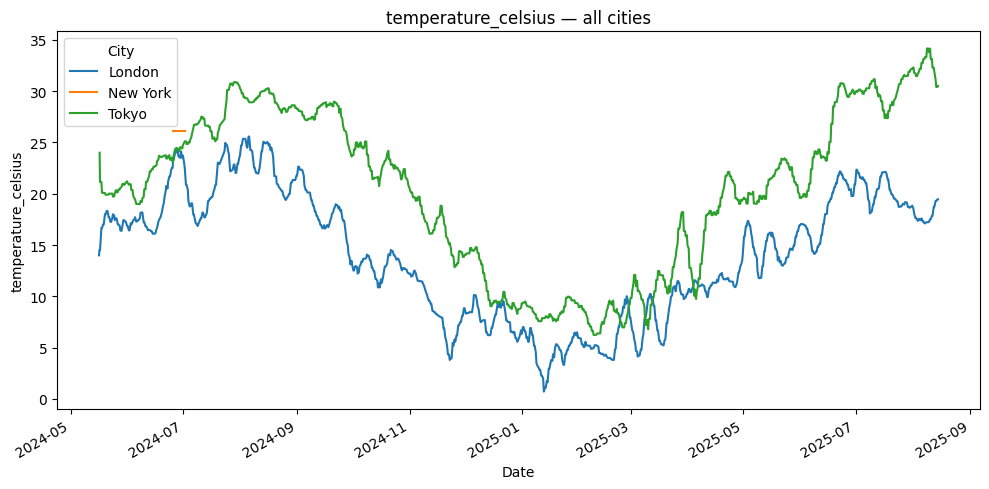

Saved: ../assets/precip_mm_ALL_CITIES.png


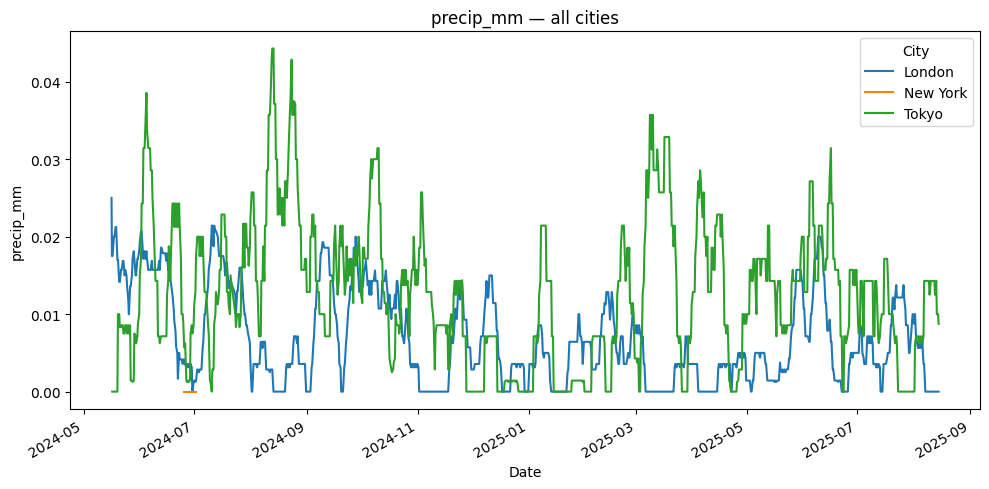

In [14]:
# EDA Line plot for all the cities 
metrics = [m for m in ["temperature_celsius", "precip_mm"] if m in df_features.columns]

for metric in metrics:
    # wide format: index=time, columns=cities, values=metric
    wide = (df_features.reset_index()
            .query(f"{CITY_COL} in @CITIES")
            .pivot(index=TIME_COL, columns=CITY_COL, values=metric)
            .sort_index())

    # optional smoothing (comment out if you want raw lines)
    wide_smooth = wide.rolling("7D").mean()

    ax = wide_smooth.plot(figsize=(10,5), title=f"{metric} — all cities")
    ax.set_xlabel("Date")
    ax.set_ylabel(metric)
    ax.legend(title="City")
    plt.tight_layout()

    out_path = ASSETS / f"{metric}_ALL_CITIES.png"
    plt.savefig(out_path, dpi=150)
    print("Saved:", out_path)
    plt.show()


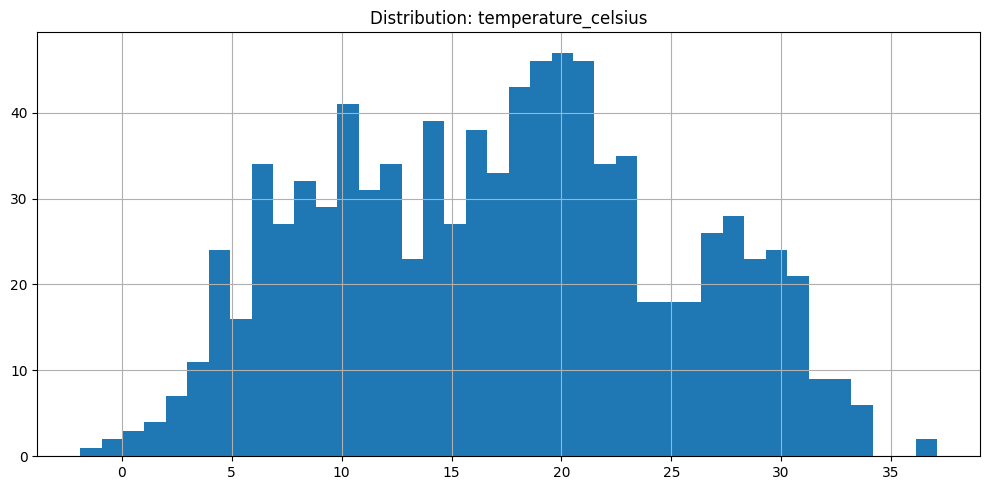

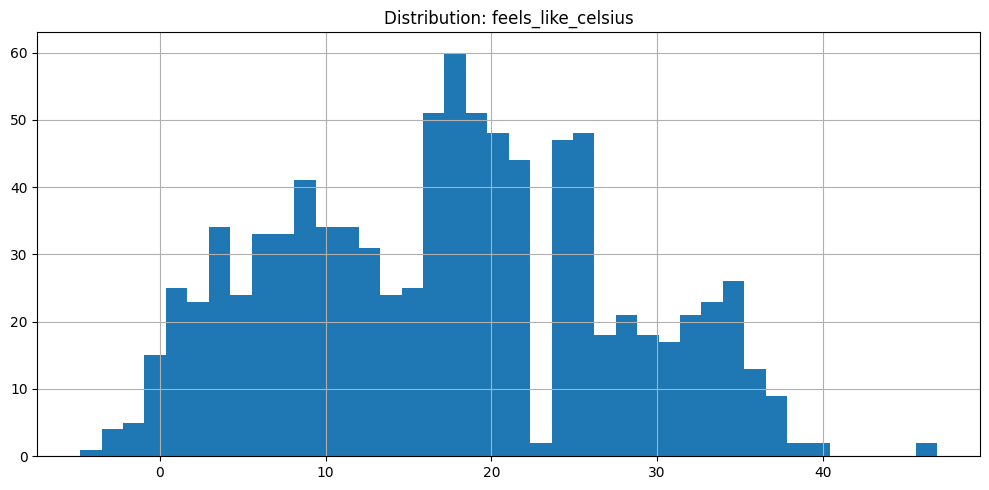

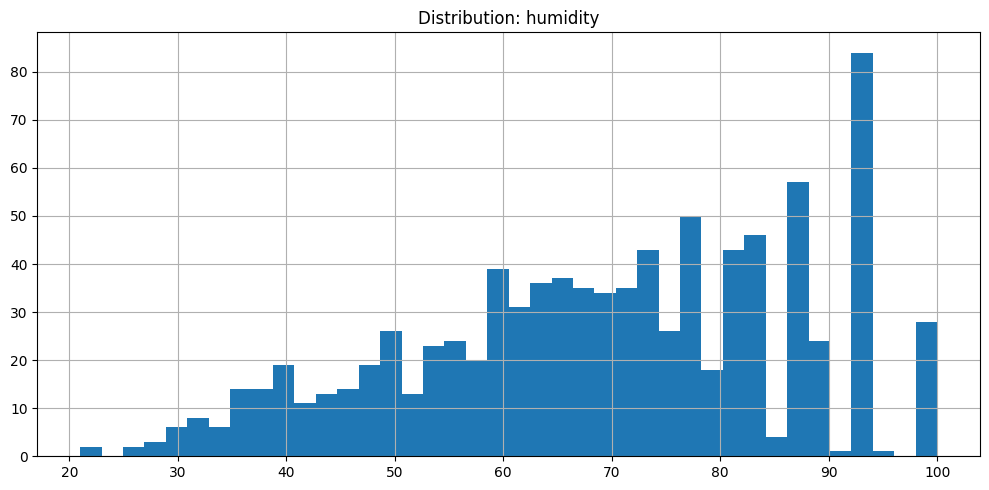

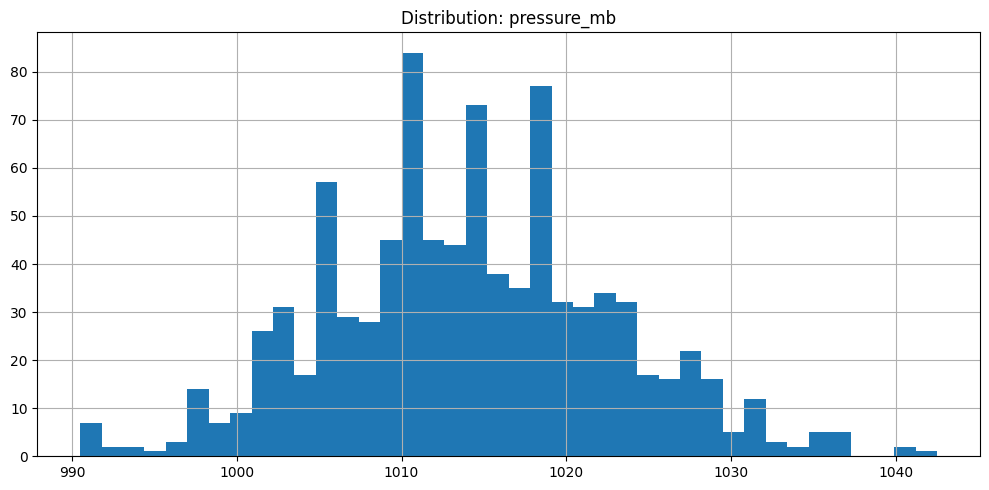

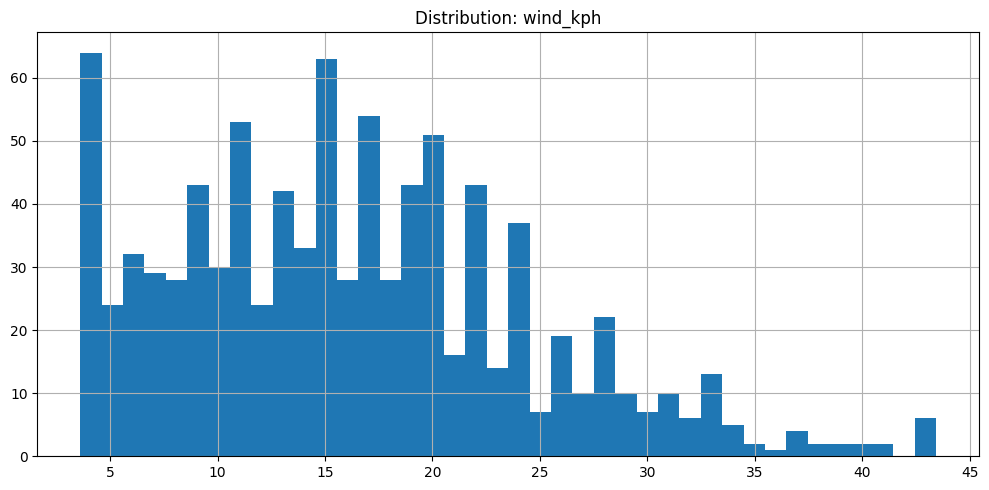

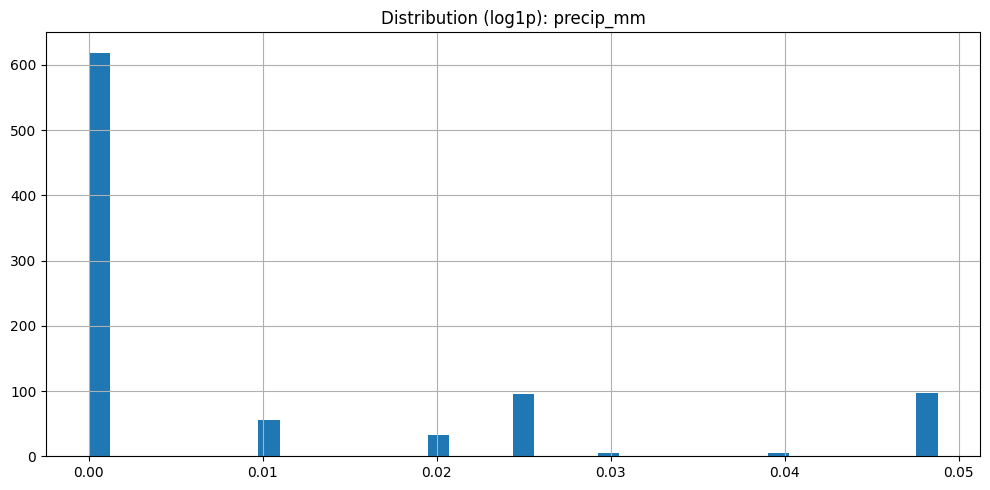

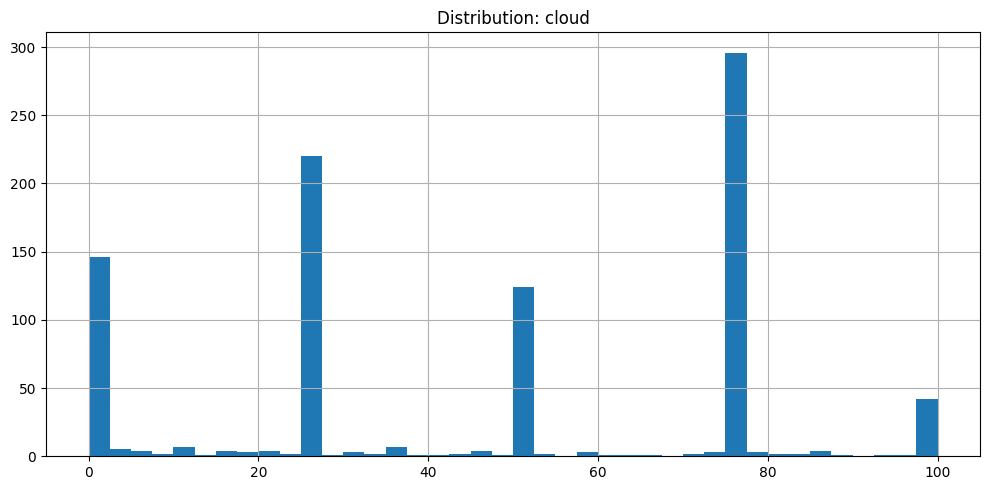

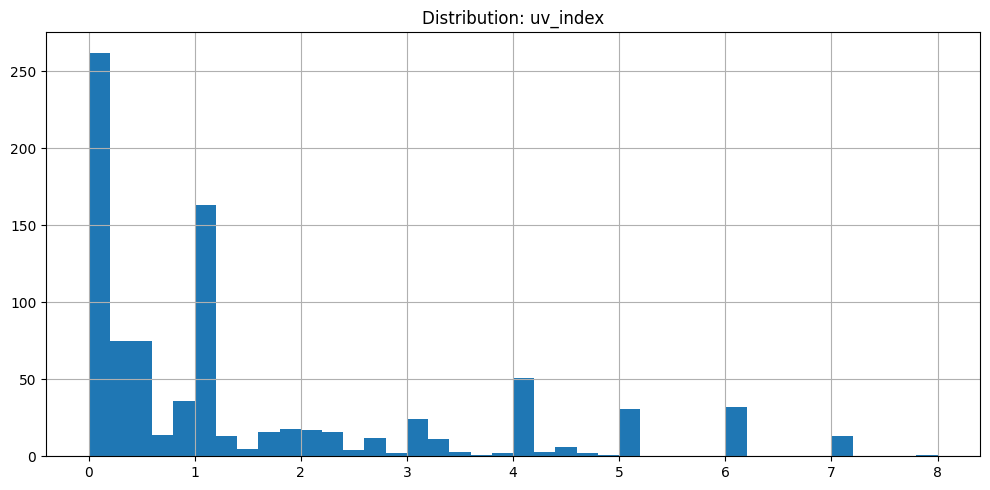

In [24]:
# EDA Distribution and Coorelation

# Histograms

for metric in NUM_COLS:
    if metric in df_features.columns:
        s = df_features[metric].dropna()
        if metric == "precip_mm":
            s = np.log1p(s)  # log(1+x) for right-skewed precipitation
            title = f"Distribution (log1p): {metric}"
        else:
            title = f"Distribution: {metric}"

        s.hist(bins=40)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(ASSETS / f"hist_{metric}.png", dpi=150)
        plt.show()

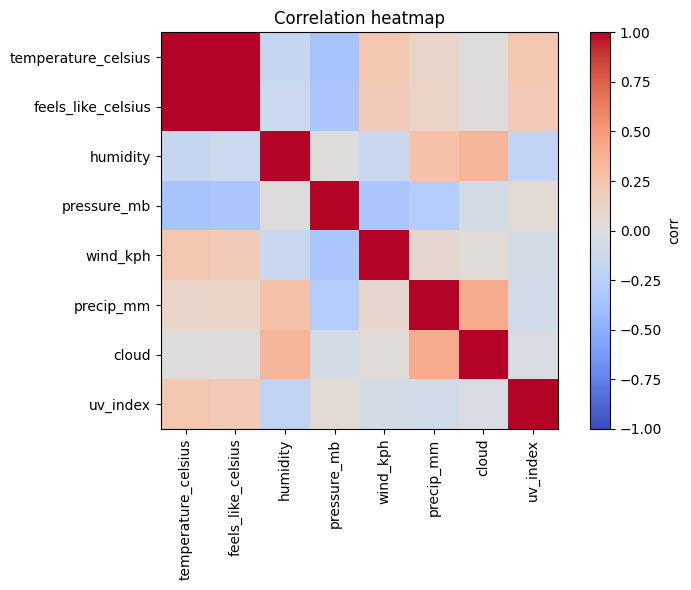

In [15]:
# Coorelation 

cols_present = [c for c in NUM_COLS if c in df_features.columns]
corr = df_features[cols_present].corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar(label="corr")
plt.tight_layout()
plt.savefig(ASSETS / "corr_heatmap.png", dpi=150)
plt.show()

In [16]:
# Save cleaned dataset CSV (readable) formats

save_clean(df_features)  # writes to ../assets/clean_weather.csv
print("Shape:", df_features.shape)

Shape: (909, 18)
